# Overview

This week is all about working with data. I'm not going to lie to you. This part might be frustrating - but frustration is an integral part of learning. Real data is almost always messy & difficult ... and learning to deal with that fact, is a key part of being a data scientist. 
> 
> **_Video Lecture_**: Since you guys will be struggling with real data today, the first lecture today is just a short, silly pep-talk to cheer you up in the midst of the tedium of working with messy wikipedia data.

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo("VlVvyWliQU8",width=800, height=450)

Enough about the process, let's get to the content. My plan for the next few lectures is to use network science and Wikipedia to learn about philosophy. We're going to download all the Wikipedia pages about philosophers from Wikipedia - and then create the network of the pages that link to each other. Next time, we'll use our network skills (as well as new ones) to understand that network. Further down the line, we'll use natural language processing to understand the text displayed on those pages. 

But for today, the tasks are

* Learn about _regular expressions_
* Find the names of all the philosopher-pages on Wikipedia
* Download and store (for later use) all the philosopher-pages from Wikipedia
* Extract all the internal wikipedia-links that connect the philosopher-pages on wikipedia
* Generate the network of philosophers on wikipedia. We'll also do a little bit of initial analysis of the network.

# Part 0: Regular expressions

Before we get started, we have to get a little head start on the _Natural Language Processing_ part of the class. This is a new direction for us, up to now, we've mostly been doing math-y stuff with Python, but today, we're going to be using Python to work through a text. The central thing we need to be able to do today, is to extract internal wikipedia links. And for that we need regular expressions.

> _Exercises_: Regular expressions round 1\.
> 
> * Read [**this tutorial**](https://developers.google.com/edu/python/regular-expressions) to form an overview of regular expressions. This is important to understand the content of the tutorial (also very useful later), so you may actually want to work through the examples.
> * Now, explain in your own words: what are regular expressions?

Regular expressions can be used to extract, match or substitute text to be able to get useful information or handle certain strings differently.

> * Provide an example of a regex to match 4 digits numbers (by this, I mean precisely 4 digits, you should not match any part of numbers with e.g. 5 digits). In your notebook, use `findall` to show that your regex works on this [test-text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/test.txt). **Hint**: a great place to test out regular expressions is: https://regex101.com.


In [10]:
r = requests.get('https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/test.txt')
print re.findall(r'\s([0-9]{4})\s', r.text)

[u'1234', u'9999']


> * Provide an example of a regex to match words starting with "super". Show that it works on the [test-text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/test.txt).
> 

In [11]:
print re.findall(r'super\w+', r.text)

[u'superpolaroid', u'supertaxidermy', u'superbeer']


Finally, we need to figure out how how to match internal wiki links. Wiki links come in two flavors. They're always enclosed in double square brackets, e.g. `[[wiki-link]]` and can either occur like this:

    ... some text [[Aristotle]] some more text ...

which links to the page [`https://en.wikipedia.org/wiki/Aristotle`](https://en.wikipedia.org/wiki/Aristotle). 

The second flavor has two parts, so that links can handle spaces and other more fancy forms of references, here's an example:

    ... some text [[Eudemus_of_Rhodes|Eudemus of Rhodos]] some more text ...

which links to the page [`https://en.wikipedia.org/wiki/Eudemus_of_Rhodes`](https://en.wikipedia.org/wiki/Eudemus_of_Rhodes). Now it's your turn.

> _Exercise_: Regular expressions round 2\. Show that you can extract the wiki-links from the [test-text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/test.txt). Perhaps you can find inspiration on stack overflow or similar. **Hint**: Try to solve this exercise on your own (that's what you will get the most out of - learning wise), but if you get stuck ... take a look at the video lecture below.
> 

In [12]:
wiki_part = 'https://en.wikipedia.org/wiki/'
matches = re.findall(r'\[\[(.+?)\]\]', r.text) # ? is non-greedy
final_links = list()
for m in matches:
    final_links.append('{0}{1}'.format(wiki_part, m.split('|')[0].replace(' ', '_')))
print final_links

['https://en.wikipedia.org/wiki/drinking_vinegar', 'https://en.wikipedia.org/wiki/gentrify', 'https://en.wikipedia.org/wiki/hashtag', 'https://en.wikipedia.org/wiki/Bicycle', 'https://en.wikipedia.org/wiki/Pitchfork']


# Part A: Download Philosopher-pages from Wikipedia

Armed with some knowledge of regular expressions, we're going to start extracting all the names of philosophers on Wikipedia. These will be the nodes of our network.

> **_Video Lecture_**: A barebones strategy for getting philosopher page names.
> 

In [13]:
YouTubeVideo("91gknsVGHls",width=800, height=450)

> _Exercise_: Find the names of all the philosopher-pages, download and analyze them.
> 
> * [This wiki-page](https://en.wikipedia.org/wiki/Lists_of_philosophers) contains list of philosophers from various branches of philosophy:
>   1. [aestheticians](https://en.wikipedia.org/wiki/List_of_aestheticians)
>   2. [epistemologists](https://en.wikipedia.org/wiki/List_of_epistemologists)
>   3. [ethicists](https://en.wikipedia.org/wiki/List_of_ethicists) 
>   4. [logicians](https://en.wikipedia.org/wiki/List_of_logicians)
>   5. [metaphysicians](https://en.wikipedia.org/wiki/List_of_metaphysicians)
>   6. [social and political philosophers](https://en.wikipedia.org/wiki/List_of_social_and_political_philosophers)


In [1]:
# import all necessary packages
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import operator
import os
import pickle
import pprint
import re
import requests
import urllib

# IPython specifics
%matplotlib inline

In [2]:
phil_links = [
    ('https://en.wikipedia.org/w/index.php?title=List_of_aestheticians&action=edit', 'aestheticians'),
    ('https://en.wikipedia.org/w/index.php?title=List_of_epistemologists&action=edit', 'epistemologists'),
    ('https://en.wikipedia.org/w/index.php?title=List_of_ethicists&action=edit', 'ethicists'),
    ('https://en.wikipedia.org/w/index.php?title=List_of_logicians&action=edit', 'logicians'),
    ('https://en.wikipedia.org/w/index.php?title=List_of_metaphysicians&action=edit', 'metaphysicians'),
    ('https://en.wikipedia.org/w/index.php?title=List_of_social_and_political_philosophers&action=edit', 'social_and_political_philosophers')
]

# get all philosopher pages wiki text
all_matches = {
    'all': set()
}
for l in phil_links:
    r = requests.get(l[0])
    soup = BeautifulSoup(r.text, 'html.parser')
    wiki_text = soup.find('textarea').get_text()
    # lines of philosophers start with "*" or "*St."
    # this link in logicians '[[Categoriae decem]]'' wasn't counted
    matches = re.findall(r'(\*\s?|\*\s?St\.\s?)\[\[(.+?)\]\]', wiki_text)
    # only 2nd group with philosopher name
    # remove any lists that can occur in the == See also == section
    m = [x[1].split('|')[0].replace(' ', '_') for x in matches if not re.match(r'list of.*', x[1], re.IGNORECASE)]
    # put in dictonary
    all_matches[l[1]] = m
    all_matches['all'] |= set(m)

pprint.pprint(all_matches)

{'aestheticians': [u'Andreas_Linder',
                   u'Virgil_Aldrich',
                   u'Anandavardhana',
                   u'Sri_Aurobindo',
                   u'John_Anderson_(philosopher)',
                   u'Yves_Marie_Andr\xe9',
                   u'Thomas_Aquinas',
                   u'Aristotle',
                   u'Rudolf_Arnheim',
                   u'Mazen_Asfour',
                   u'Georg_Anton_Friedrich_Ast',
                   u'Augustine_of_Hippo',
                   u'Jody_Azzouni',
                   u'Victor_Basch',
                   u'Yusuf_Balasagun',
                   u'Roland_Barthes',
                   u'Georges_Bataille',
                   u'Alexander_Gottlieb_Baumgarten',
                   u'Monroe_Beardsley',
                   u'Vissarion_Belinsky',
                   u'Clive_Bell',
                   u'Walter_Benjamin',
                   u'Arnold_Berleant',
                   u'George_Birkhoff',
                   u'Max_Black',
           

In [3]:
### save the dict with all matched philosophers in categories (needed in week5)
# create dir if not exists
directory = '../philosophers'
if not os.path.exists(directory):
    os.makedirs(directory)

# store philosopher data in one small binary file
with open('{0}/cat.pkl'.format(directory), 'wb') as f:
    pickle.dump(all_matches, f)

> 
> We're going to have to go and extract the page names for all six groups of philosophers. Unfortunately wikipedia does not have a uniform way of setting such pages up, so you'll have to do each page differently. And I'd like you to maintain **seven** (7) separate lists of philosophers. One for each branch of philosophy - and one combined list of all philosophers. 
> 
> * Let's put together some descriptive statistics:
>   * How many philosophers in each list? How many total?



In [17]:
for x in all_matches:
    if x == 'all':
        print 'All (unique) philosophers together are:', len(all_matches[x])
    else:
        print 'Philosophers in list "{0}" are all together {1}'.format(x, len(all_matches[x]))

All (unique) philosophers together are: 1010
Philosophers in list "aestheticians" are all together 126
Philosophers in list "logicians" are all together 271
Philosophers in list "epistemologists" are all together 99
Philosophers in list "social_and_political_philosophers" are all together 295
Philosophers in list "metaphysicians" are all together 96
Philosophers in list "ethicists" are all together 272


>   * Which is the largest branch of philosophy?


In [18]:
largest_branch = (0, None)
for x in all_matches:
    if x == 'all':
        continue
    if len(all_matches[x]) > largest_branch[0]:
        largest_branch = (len(all_matches[x]), x)
print 'The largest branch is "{0}" with {1} members'.format(largest_branch[1], largest_branch[0])

The largest branch is "social_and_political_philosophers" with 295 members


In [19]:
cnt = Counter()
for x in all_matches:
    if x == 'all':
        continue
    cnt[x] = len(all_matches[x])

maximum = max(list(cnt.values()))
# there might be more than one maximum, thus iterate
for x in cnt:
    if cnt[x] == maximum:
        print 'The largest branch is "{0}" with {1} members.'.format(x, maximum)

The largest branch is "social_and_political_philosophers" with 295 members.


>   * Are some philosophers in more than one list?

In [20]:
cnt = Counter()
for x in all_matches:
    if x == 'all':
        continue
    for i in all_matches[x]:
        cnt[i] += 1
print 'There are {0} philosophers in more than one list.'.format(len([x for x in cnt if cnt[x] > 1]))

There are 117 philosophers in more than one list.


>   * Which philosopher is in most lists & and how many?

In [21]:
cnt = Counter()
for x in all_matches:
    if x == 'all':
        continue
    for i in all_matches[x]:
        cnt[i] += 1
        
maximum = max(list(cnt.values()))
# there might be more than one maximum, thus iterate
for x in cnt:
    if cnt[x] == maximum:
        print 'The philosopher {0} is in {1} lists.'.format(x, maximum)

The philosopher Thomas_Aquinas is in 6 lists.
The philosopher Aristotle is in 6 lists.


>   * Let's investigate philosophers active in multiple sub-fields. Create a list of every philosopher that occurs in more than one list. Use Python to sort the list according to how many lists each philosopher belongs to (so the guy you found in the previous question is first in that list).
> 

In [33]:
cnt = Counter()
for x in all_matches:
    if x == 'all':
        continue
    for i in all_matches[x]:
        cnt[i] += 1
print sorted([(x, cnt[x]) for x in cnt if cnt[x] > 1], key=lambda x: x[1], reverse=True)

[(u'Thomas_Aquinas', 6), (u'Aristotle', 6), (u'Plato', 5), (u'Bertrand_Russell', 5), (u'Immanuel_Kant', 5), (u'Ayn_Rand', 4), (u'Georg_Wilhelm_Friedrich_Hegel', 3), (u'S\xf8ren_Kierkegaard', 3), (u'Ludwig_Wittgenstein', 3), (u'Judith_Butler', 3), (u'Nelson_Goodman', 3), (u'David_Hume', 3), (u'John_Stuart_Mill', 3), (u'Ruth_Barcan_Marcus', 3), (u'Mario_Bunge', 3), (u'Susan_Haack', 3), (u'John_Locke', 3), (u'Arthur_Schopenhauer', 3), (u'Gottfried_Leibniz', 3), (u'Mortimer_Adler', 2), (u'Peter_Unger', 2), (u'Friedrich_Nietzsche', 2), (u'Socrates', 2), (u'Peter_Geach', 2), (u'Gottlob_Frege', 2), (u'Mozi', 2), (u'Robert_Nozick', 2), (u'Martin_Heidegger', 2), (u'Baruch_Spinoza', 2), (u'Kit_Fine', 2), (u'Maurice_Blanchot', 2), (u'John_Finnis', 2), (u'Augustine_of_Hippo', 2), (u'J._J._C._Smart', 2), (u'Martin_Luther_King,_Jr.', 2), (u'Jean-Jacques_Rousseau', 2), (u'Georges_Bataille', 2), (u'Michel_Foucault', 2), (u'Giambattista_Vico', 2), (u'Paul_Benacerraf', 2), (u'Constantin_R\u0103dulescu-M

Now that we have the names, it's time to download all of the pages. Use your experience with APIs from Week 1\. To get started, I **strongly** recommend that you re-watch the **APIs video lecture** from that week - it contains lots of useful tips on this specific activity (yes, I had planned this all along!). I've included it below for your covenience.

In [23]:
YouTubeVideo("9l5zOfh0CRo",width=800, height=450)

> _Exercise_: Download wikipages and save them to your own computer. For each of the philosophers in the _combined list_ obtained in the previous exercise, use Wikipedia's API to download the full page content (using python) and save it (get it in `json` format, _AND **don't** get the `html` version of the page which is much more difficult to parse_). 
>
> This is an important point, so I will repeat it: **Don't** get the `html` version of the page (which is much more difficult to parse_), get the standard [wiki markup](https://en.wikipedia.org/wiki/Help:Wiki_markup) which is what you see when you press "edit" on a wikipedia page.
>
> A couple of extra tips below:
> 
> * Some pages contain unicode characters, so we recommend you save the files using the [`io.open`](http://stackoverflow.com/questions/5250744/difference-between-open-and-codecs-open-in-python) method with `utf-8` encoding
> * Some philosopher names have spaces. As a first stab, try to simply substitute spaces with underscores. (E.g. `https://en.wikipedia.org/wiki/Thomas_Aquinas` from `Thomas Aquinas`. If that doesn't work, you can construct the api-url using `urllib.quote` (or similar). This is another way of handling spaces using and other non-ascii characters in `url`s using [url encoding](http://www.w3schools.com/tags/ref_urlencode.asp).
> * Store the content of all pages. It's up to you how to do this. One strategy is to use Python's built in `pickle` format. Or you can simply write the content of wiki-pages to text files and store those in a folder on your computer. I'm sure there are other ways. It's crucial that you store them in a way that's easy to access, since we'll use these pages a lot throughout the remainder of the course (so you don't want to retrieve them from wikipedia every time).
> 

In [4]:
# wikipedia API parameters
baseurl = "https://en.wikipedia.org/w/api.php"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

# get content key: philosopher name, value: json
data = dict()
for p_name in all_matches['all']:
    # replace special cahrs in philosopher name with URL encoded
    title = 'titles={0}'.format(urllib.quote(p_name.encode('utf-8')))
    # concatenate wikipedia query
    url = '{0}?{1}&{2}&{3}&{4}'.format(baseurl, action, title, content, dataformat)
    r = requests.get(url)
    data.update({p_name:r.text})

# store philosopher data in one small binary file
with open('{0}/dat.pkl'.format(directory), 'wb') as f:
    pickle.dump(data, f)

# Part B: Building the networks

Now, we're going to build a NetworkX directed graph of the links between pages. For each philosopher page, we'll find all the links to other characters, and for each link add an edge in the graph. 
> 
> _Exercise_: Build the philosopher network. The **combined list** from above provides the network nodes. We will use info from the pages to define links. Every time philosopher A's page links to philosopher B's page, we create a directed link from A to B. There are many ways to do this, but below, I've tried to break it down into natural steps.
> 
> * Use a regular expression to extract all outgoing links from each of the pages you downloaded above. There are many ways to iterate over pages - feel free to choose the one that matches the way you've chosen to store the pages.
> * For each link you extract, check if the target is in the list you generated above. If yes, keep it. If no, discard it.
> * Use a NetworkX [`DiGraph`](http://networkx.lanl.gov/reference/classes.digraph.html) to store the network.
> 

In [25]:
# get data dictionary
with open('{0}/dat.pkl'.format(directory), 'rb') as f:
    dat = pickle.load(f)

# create one node per philosopher name (keys of data)
p_graph = nx.DiGraph()
p_graph.add_nodes_from(dat.keys()) 

In [26]:
# create node links
for p in dat:
    p_content = dat[p]
    # find all wiki links in the content
    p_links = re.findall(r'\[\[(.+?)\]\]', p_content)
    # list with all outgoing links for edges
    # decode unicode chars and clean the link for matching
    out_links = [l.decode('unicode-escape').split('|')[0].replace(' ', '_') for l in p_links]

    # intersection between all philosophers and found links in article
    all_edges = set(dat.keys()).intersection(out_links)
    # show example of related philosophers
    if p == 'Immanuel_Kant':
        print all_edges

    # add an edge for the philosopher
    for e in all_edges:
        p_graph.add_edge(p, e)

set([u'Jean_Piaget', u'Johann_Gottfried_Herder', u'Friedrich_Wilhelm_Joseph_von_Schelling', u'August_Wilhelm_Schlegel', u'Baruch_Spinoza', u'Roger_Scruton', u'John_Locke', u'Ren\xe9_Descartes', u'Gotthold_Ephraim_Lessing', u'Robert_Nozick', u'Plato', u'John_McDowell', u'Arthur_Schopenhauer', u'Jean-Jacques_Rousseau', u'Houston_Stewart_Chamberlain', u'Nicolai_Hartmann', u'Gottfried_Leibniz', u'David_Hilbert', u'Christian_Wolff_(philosopher)', u'P._F._Strawson', u'Epicurus', u'Gilles_Deleuze', u'Bertrand_Russell', u'Georg_Simmel', u'Friedrich_Nietzsche', u'Michel_Foucault', u'Alexander_Gottlieb_Baumgarten', u'Thomas_Henry_Huxley', u'Wilhelm_Dilthey', u'Charles_Sanders_Peirce', u'David_Hume', u'John_Rawls', u'S\xf8ren_Kierkegaard', u'Christine_Korsgaard', u'C._D._Broad', u'Georg_Wilhelm_Friedrich_Hegel', u'Martin_Heidegger', u'Derek_Parfit', u'Noam_Chomsky', u'Aristotle', u'Adam_Smith', u'J\xfcrgen_Habermas', u'Joxe_Azurmendi'])


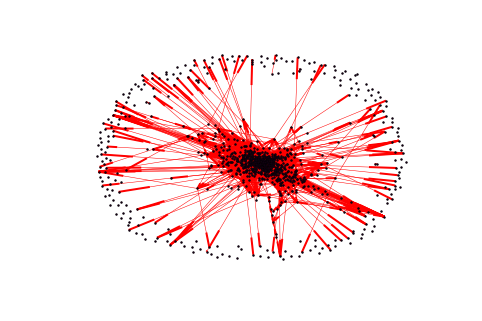

In [27]:
pos = nx.spring_layout(p_graph)
nx.draw(p_graph, pos,node_size=2, edge_color='r', node_color='m', width=0.5)
plt.figure(num=None, figsize=(8, 8), dpi=1200)
plt.show()

# Part C: Analyzing the networks

Now that we have the network, it's time to do a preliminary analysis of it (we'll go more in depth next time).

> _Exercise_: Begin to analyze the philosopher network.
> 
> * Why do you think we want to use a directed graph? Could have we used an undirected graph instead?


No we couldn't use an undirected graph that would imply that one philosopher is linked with another one although there is only a link on one philosophers page.

> * What is the total number of nodes in the network? What is the total number of links? What's the average degree? What's the median degree?


In [28]:
print 'Philosopher network has {0} nodes.'.format(p_graph.number_of_nodes())
print 'Philosopher network has {0} links.'.format(p_graph.number_of_edges())

deg_sequence = sorted(nx.degree(p_graph).values(), reverse=True)

dmean = np.mean(deg_sequence)
dmedian = np.median(np.array(deg_sequence))

print 'The average degree in the philosopher network is', dmean
print 'The median degree in the philosopher network is', dmedian

Philosopher network has 1010 nodes.
Philosopher network has 4453 links.
The average degree in the philosopher network is 8.81782178218
The median degree in the philosopher network is 4.0


> * List the top 10 philosophers by in-degree and out-degree. What is the interpretation of in-degree and out-degree in this case?


In [29]:
print 'Top 10 philosophers by in-degree:\n', sorted(p_graph.in_degree_iter(), key=operator.itemgetter(1), reverse=True)[0:10]
print '\n\nTop 10 philosophers by out-degree:\n', sorted(p_graph.out_degree_iter(), key=operator.itemgetter(1), reverse=True)[0:10]

Top 10 philosophers by in-degree:
[(u'Immanuel_Kant', 129), (u'Aristotle', 121), (u'Plato', 89), (u'Bertrand_Russell', 85), (u'Karl_Marx', 81), (u'Friedrich_Nietzsche', 65), (u'David_Hume', 65), (u'Ludwig_Wittgenstein', 63), (u'Georg_Wilhelm_Friedrich_Hegel', 57), (u'John_Stuart_Mill', 57)]


Top 10 philosophers by out-degree:
[(u'Georg_Wilhelm_Friedrich_Hegel', 49), (u'Friedrich_Nietzsche', 44), (u'Immanuel_Kant', 43), (u'Bertrand_Russell', 40), (u'Martin_Heidegger', 40), (u'David_Hume', 38), (u'S\xf8ren_Kierkegaard', 33), (u'John_Stuart_Mill', 32), (u'Plato', 31), (u'Jean-Jacques_Rousseau', 31)]


The in-degree relates to how many edges link to the philosopher from other philosophers which could indicate how many built on top of his work or are in some way related or refer to him. According to that Kant was most refered to by other philosophers.

The out degree shows how one particular philosopher is in some connection with others. Hegel has the most connections with other philosophers. For example quoted from [Kant's wikipedia entry](https://en.wikipedia.org/wiki/Immanuel_Kant#Historical_influence): _He had an influence on Reinhold, Fichte, Schelling, Hegel, and Novalis during the 1780s and 1790s._

> Have you heard about these philosophers before?

Yes these philosophers are all known to us. No matter if Denmark, China or Germany we all talked about them in school. The one's out of the top 10 are, however, less known.

> * Plot the distribution of in-degrees and out-degrees, binned using `numpy.histogram`. What is the most common degree?

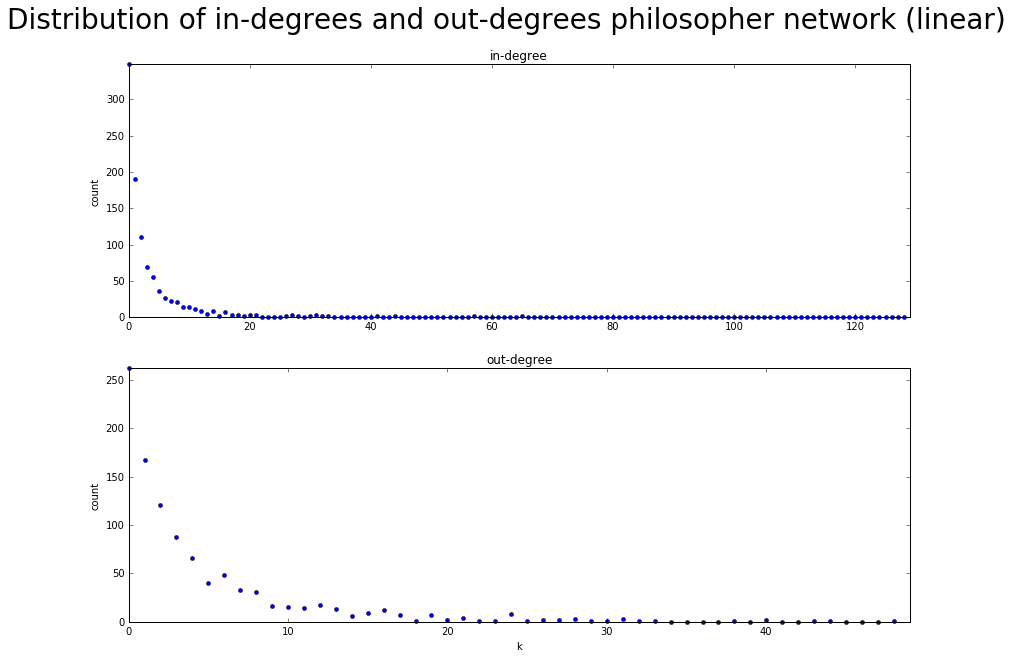

Most common in-degree: 1.0
Most common out-degree: 2.0


In [30]:
deg_sequence_in = sorted(p_graph.in_degree().values(), reverse=True)
dmax_in = max(deg_sequence_in)
dmin_in = min(deg_sequence_in)

deg_sequence_out = sorted(p_graph.out_degree().values(), reverse=True)
dmax_out = max(deg_sequence_out)
dmin_out = min(deg_sequence_out)

# set figure
fig = plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Distribution of in-degrees and out-degrees philosopher network (linear)', fontsize=28)

# generate histograms
p_bin_in = xrange(dmin_in, dmax_in+1)
hist_in, bin_edg_in = np.histogram(deg_sequence_in, bins=p_bin_in)

p_bin_out = xrange(dmin_out, dmax_out+1)
hist_out, bin_edg_out = np.histogram(deg_sequence_out, bins=p_bin_out)

# set histogram data and dimension
plt.subplot('211')
plt.plot(bin_edg_in[:-1], hist_in, 'ro', color='blue', markersize=4, clip_on=False)
plt.axis([min(bin_edg_in), max(bin_edg_in), min(hist_in), max(hist_in)])

plt.ylabel("count")
plt.title("in-degree")

plt.subplot('212')
plt.plot(bin_edg_out[:-1], hist_out, 'ro', color='blue', markersize=4, clip_on=False)
plt.axis([min(bin_edg_out), max(bin_edg_out), min(hist_out), max(hist_out)])
plt.xlabel('k')
plt.ylabel('count')
plt.title("out-degree")
plt.show()

print "Most common in-degree:", np.median(np.array(deg_sequence_in))
print "Most common out-degree:", np.median(np.array(deg_sequence_out))

The most common out and in-degree relate to the median degree.

> * Plot the distribution of in-degrees and out-degrees one more time, this time plotted loglog scale.

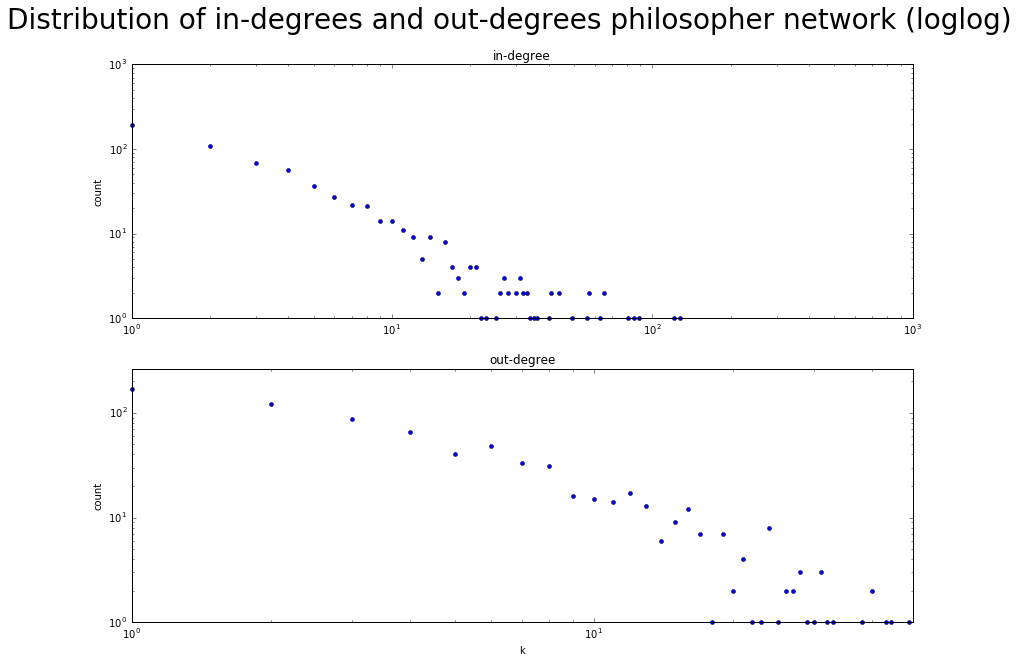

In [31]:
fig = plt.figure(num=None, figsize=(14, 10), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Distribution of in-degrees and out-degrees philosopher network (loglog)', fontsize=28)

plt.subplot('211')
plt.loglog(bin_edg_in[:-1], hist_in, 'ro', color='blue', markersize=4, clip_on=False)
plt.ylabel("count")
plt.title("in-degree")

plt.subplot('212')
plt.loglog(bin_edg_out[:-1], hist_out, 'ro', color='blue', markersize=4, clip_on=False)
plt.axis([min(bin_edg_out), max(bin_edg_out), min(hist_out), max(hist_out)])
plt.xlabel('k')
plt.ylabel('count')
plt.title("out-degree")
plt.show()

> * Describe the distributions (as you would in a well written figure caption). Do they look Poissonian? Power-law? Something in between?

* The in-degree distribution in the philosophers network follows the power-law. A popular philosopher gets much more attention. The incoming links follow preferential attachment. 
* The out-degree distribution follows something between power-law and poisson, because a document cannot be infinitely long and thus have innumerable out-degree links.

> * Plot a scatter plot of the the in- versus out- degree for all philosophers using a loglog scale. Comment on the relation between the two.

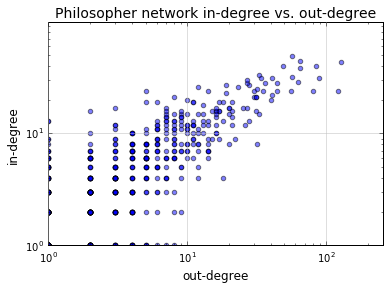

Correlation coefficient is: 0.792635683708


In [32]:
in_deg_val = p_graph.in_degree().values()
out_deg_val = p_graph.out_degree().values()

fig, ax = plt.subplots()

ax.set_title("Philosopher network in-degree vs. out-degree", fontsize=14)
ax.set_xlabel("out-degree", fontsize=12)
ax.set_ylabel("in-degree", fontsize=12)

ax.grid(True, linestyle='-', color='0.75')
ax.set_xlim([1, max(in_deg_val) * 2])
ax.set_ylim([1, max(out_deg_val) * 2])
ax.set_xscale('log')
ax.set_yscale('log')

plt.scatter(in_deg_val, out_deg_val, alpha=0.5)

plt.show()

print 'Correlation coefficient is: {0}'.format(np.corrcoef(x=out_deg_val, y=in_deg_val)[0,1])


The relation between the two plots is positive correlation. (Correlation coefficient between in and out-degree is around 0.79)